<a href="https://colab.research.google.com/github/Polinia/projects_Portfolio/blob/main/module_8/car_price_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Objectives: to predict car price based on its characteristics, text description or photo. 

## Objectives:
* to build a "naive" / baseline model that predicts the price by model and 
year of manufacture (we will compare other models with it) 
* to process and normalize features
* to make the first model based on gradient boosting using CatBoost
* to make a second model based on neural networks and compare the results
* to build a multi-input neural network to analyze tabular data and text at the same time
* to add image processing to the multi-input network
* to build an ensemble of gradient boosting and neural network (averaging their predictions)

In [1]:
!pip install pymorphy2 -q
!pip install pymorphy2-dicts -q
!pip install -q tensorflow==2.3
#image augmentation
!pip install albumentations -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.3.0 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
xarray-einstats 0.3.0 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
tifffile 2022.10.10 requires numpy>=1.19.2, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
jax 0.

In [9]:
!pip install numpy==1.19.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.5 MB 26.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.3.0 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.2 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.2 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you 

In [2]:
# Import Libraries
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2
!pip install catboost -q
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
!pip install category_encoders
import category_encoders as ce
# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers.schedules import *
import albumentations

# plt
import matplotlib.pyplot as plt
#increase the default chart size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#charts in svg look clearer
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# check versions
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.8.16 (default, Dec  7 2022, 01:12:13) 
Numpy        : 1.19.2
Tensorflow   : 2.3.0


In [4]:
#function for metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# fix the version of the packages so that the experiments are reproducible:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

# DATA

Let's look at the types of signs:

* bodyType - categorical
* brand - categorical
* color - categorical
* description - text
* engineDisplacement - numeric, represented as text
* enginePower - numeric, represented as text
* fuelType - categorical
* mileage - numeric
* modelDate - numeric
* model_info - categorical
* name - categorical, it is better to reduce the dimension - not used (combination of other columns)
* numberOfDoors - categorical
* price - numeric, target
* productionDate - numeric
* sell_id - image (file available at address based on sell_id)
* vehicleTransmission - categorical
* vehicleConfiguration —not used (combination of other columns)
* Владельцы - categorical
* Владение - numeric, represented as text
* ПТС - categorical
* Привод - categorical
* Руль - categorical

In [8]:
DATA_DIR = '/content/sample_data/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
pd.set_option('display.max_columns', None)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

# Model 1: Let's create a baseline model
This model will predict the average price by model and year.
We will compare other models with it.



In [52]:
# split the data
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [53]:
# baseline
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

#fill in the missing matches
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# rounded
predicts = (predicts // 1000) * 1000

# evaluate accuracy
print(
    f"MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

MAPE: nan%


# EDA

Let's do a quick analysis of the data for better understanding whether our algorithm can work with this data.
EDA and Feature Engineering was prepared based on previously completed code in the previous CarPricePrediction project, where we worked with the same team.

Let's see how the distributions of numerical features look like:

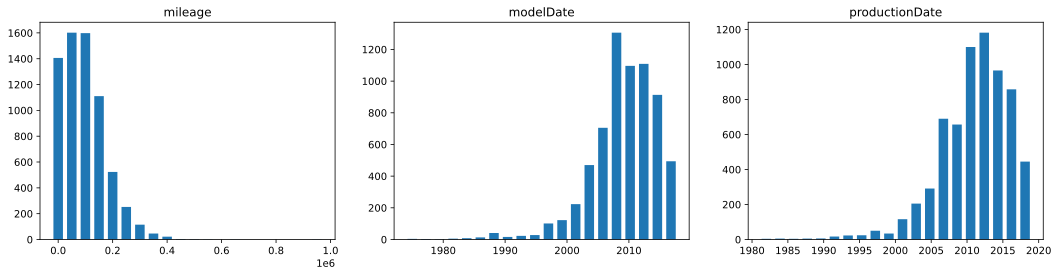

In [22]:
#numerical features distribution:
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

CatBoost is be able to work with features in this form, but the neural network needs normalized data.

In [23]:
# use the module for quick primary data analysis
import pandas_profiling
# pandas_profiling.ProfileReport(data)

Brief summary: there are 6682 ads in the training sample, 1671 in the test sample. There are 8353 ads in total. There are 23 variables. Of the numerical features, we have: mileage, modelDate, numberOfDoors, productionDate. The rest are of type Object. There are gaps in the features Owners and Ownership. Also, the feature sample was added to indicate the ownership of the data and subsequent separation

# PreProc Tabular Data

In [10]:
# for the correct processing of features, we combine the train and the test into one dataset
train['sample'] = 1 # train
test['sample'] = 0 # test
test['price'] = 0 # we do not have a price value in the test, we must predict it, so for now we just fill it with zeros

data = test.append(train, sort=False).reset_index(drop=True) # combine
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [11]:
# rename some columns
data.rename(columns = {'Владельцы':'owners', 'Владение': 'Ownership', 'ПТС':'vehicle_licence', 'Привод':'drive_type',
                       'Руль':'wheel','Состояние':'condition','Таможня':'customs_clearance'}, inplace = True )

**bodyType**

In [12]:
data['bodyType'] = data['bodyType'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

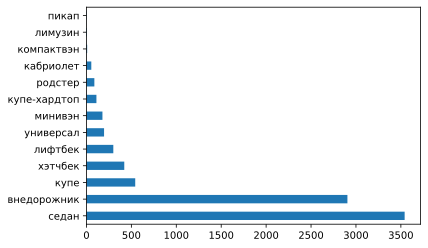

In [27]:
#let's look at the distribution
data.bodyType.value_counts().plot.barh() 

**color**

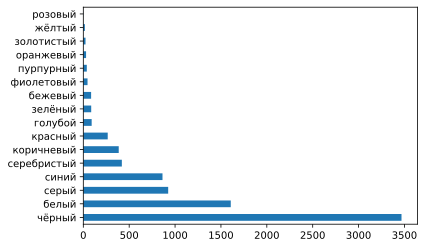

In [28]:
data.color.value_counts().plot.barh()

**fuelType**

In [29]:
data.fuelType.value_counts() #categorical feature

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

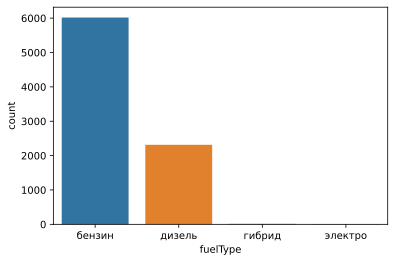

In [30]:
sns.countplot(x = 'fuelType', data = data)

**engineDisplacement**

In [31]:
data.engineDisplacement.value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
6.6 LTR             5
1.9 LTR             5
5.8 LTR             5
4.6 LTR             5
4.3 LTR             4
3.4 LTR             4
3.8 LTR             3
6.3 LTR   

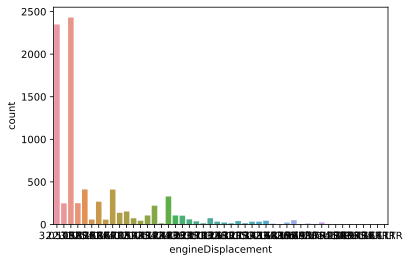

In [32]:
sns.countplot(x = 'engineDisplacement', data = data)

**enginePower**

In [33]:
data.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [13]:
#preprocessing the "enginePower"
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7').astype('int')

<bound method Axes.barh of <matplotlib.axes._subplots.AxesSubplot object at 0x7fbddde78d30>>

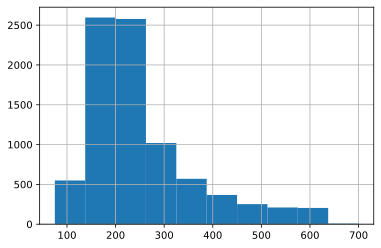

In [35]:
data.enginePower.hist().barh

**mileage**

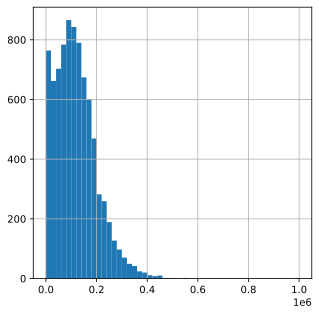

In [36]:
data['mileage'].hist(figsize=(5,5), bins=50)

then we will add to the numerical features and apply normalization

**modelDate**

AxesSubplot(0.125,0.125;0.775x0.755)


count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

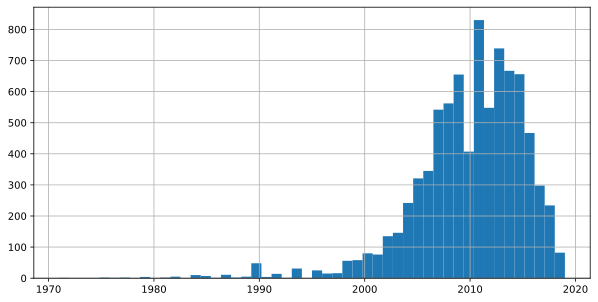

In [37]:
print(data['modelDate'].hist(figsize=(10,5), bins=50))
data['modelDate'].describe()

AxesSubplot(0.125,0.125;0.775x0.755)


count    8353.000000
mean     2012.010775
std         5.107314
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

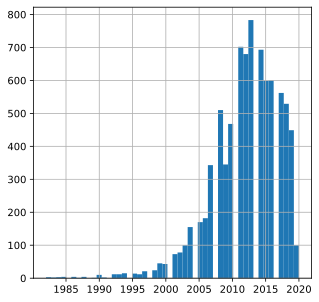

In [38]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))
data['productionDate'].describe()

In [14]:
#create new features based on the existing ones: the number of years of production and the age of the model
data['model_age'] = 2021 - data.modelDate

In [15]:
#generate a feature 'mileage_per_year'
data['mile_per_year'] = data['mileage'] / data['model_age']

**numberOfDoors**

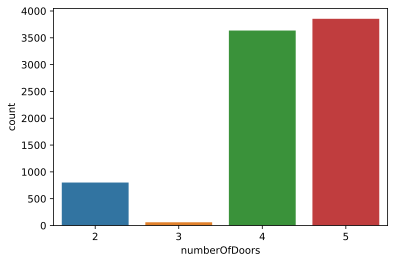

In [41]:
sns.countplot(x = 'numberOfDoors', data = data)

classify as categorical

**vehicleTransmission**

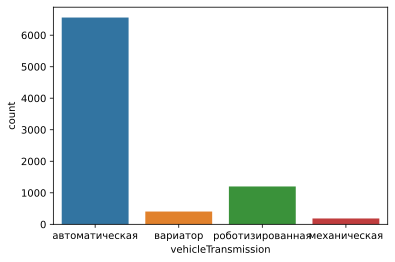

In [42]:
sns.countplot(x = 'vehicleTransmission', data = data)

classify as categorical

**owners**

In [45]:
data['owners'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: owners, dtype: int64

In [16]:
# convert the data, leave only the numeric value
data['owners'].fillna('3 an more', inplace=True)
data['owners'] = data['owners'].apply(
    lambda x: int(x[0])).astype('int32')

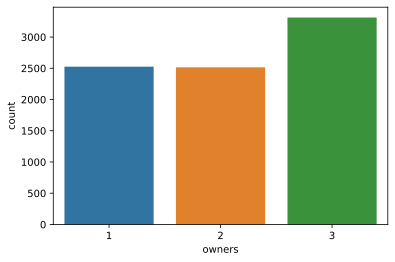

In [47]:
sns.countplot(x = 'owners', data = data)

In [57]:
data.owners.isna().sum()  

0

5418 gaps out of 8353 values is the majority. I see no reason to leave it.

**model_info**

In [58]:
data.model_info.value_counts() #classify as categorical

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
None          1
Z8            1
COUPE         1
Z3M           1
W201          1
Name: model_info, Length: 122, dtype: int64

**vehicle licence**

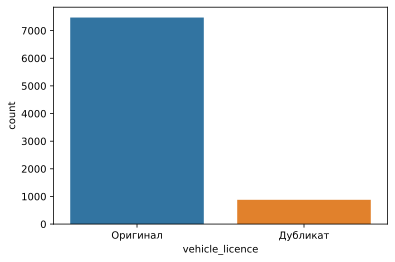

In [59]:
sns.countplot(x = 'vehicle_licence', data = data)

**Drive type**

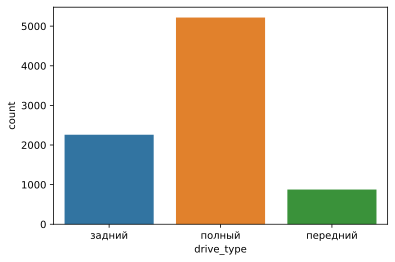

In [60]:
#look at the distribution
sns.countplot(x = 'drive_type', data = data)

**wheel**

Левый     8351
Правый       2
Name: wheel, dtype: int64

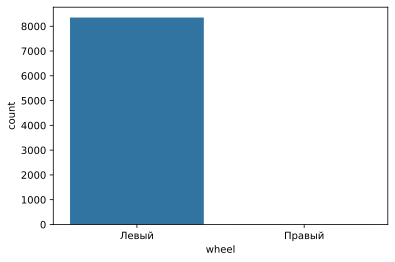

In [61]:
sns.countplot(x = 'wheel', data = data)
data.wheel.value_counts()

vehicle_licence, drive_type, and wheel classify as categorical

**name**

In [62]:
data.name.head(10)

0                 300 3.0 AT (220 л.с.)
1    640d xDrive 3.0d AT (313 л.с.) 4WD
2           325xi 2.5 AT (218 л.с.) 4WD
3                318i 2.0 AT (136 л.с.)
4    520d xDrive 2.0d AT (190 л.с.) 4WD
5     540i xDrive 3.0 AT (340 л.с.) 4WD
6                3.0d AT (245 л.с.) 4WD
7                 350 3.5 AT (316 л.с.)
8                    1.8 CVT (170 л.с.)
9                    1.8 CVT (160 л.с.)
Name: name, dtype: object


The 'name' attribute contains data that is already in other columns. Let's reduce the dimension by highlighting the presence of xDrive as a separate attribute, and remove the name attribute

In [17]:
#generating new feature:
data['name_xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

**Target variable distribution:**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

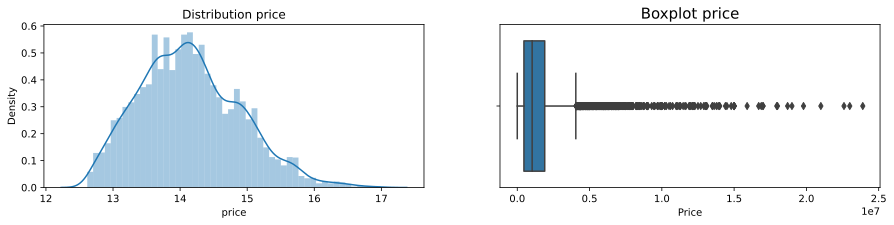

In [64]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Distribution {'price'}")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Boxplot {'price'}", fontsize=15)
plt.show()
data.price.describe()

We will not remove outliers, but we will take their logarithm in the future

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


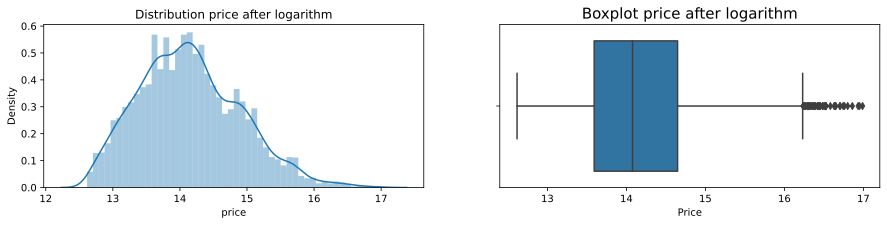

In [65]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Distribution {'price'} after logarithm")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Boxplot price after logarithm', fontsize=15)
plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


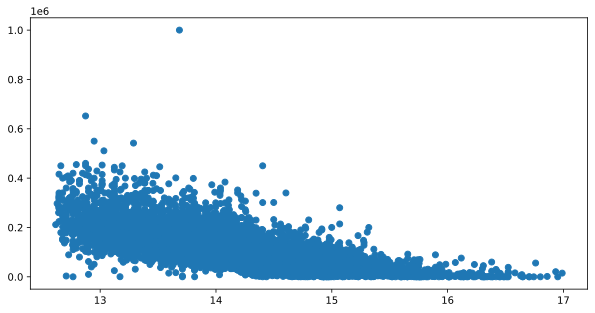

In [66]:
#Let's look at the distribution of price dependence on mileage
plt.figure(figsize=(10, 5))
plt.scatter(np.log(data.price), data.mileage)

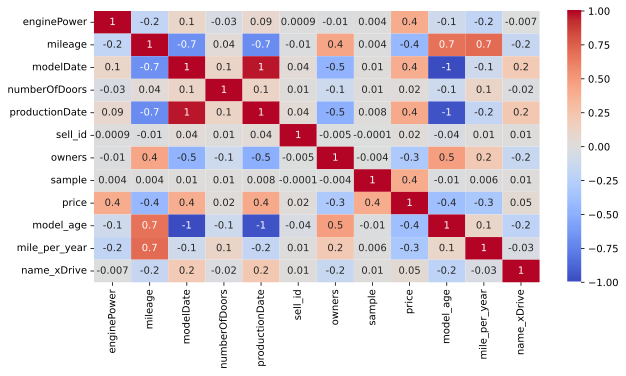

In [67]:
# correlation

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

We see a strong correlation between:

model_age and modelDate

model_age and productionDate

modelDate|productionDate and mileage

Next, remove either modelDate or productionDate

In [18]:
#use all text features as categorical features without preprocessing
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'owners', 'vehicle_licence', 'drive_type', 'wheel', 'name_xDrive']

#use all numeric features
numerical_features = ['mileage', 'productionDate','model_age','enginePower', 'mile_per_year']

In [19]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Preprocessing #####################################
    #remove features that are unnecessary for the model
    df_output.drop(['description', 'sell_id', 'vehicleConfiguration',
                   'Ownership', 'name', 'modelDate'], axis=1, inplace=True)

    # ################### Numerical Features ##################################
    # filling gaps
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)


    ############################### Log #######################################
    # It is desirable to feed data into the neural network with a distribution close to normal,
    # therefore, it makes sense to take a logarithm from some numerical features before normalization.

    # Normalization
    scaler = RobustScaler()  # we apply exactly this standardization, since it is resistant to outliers
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: will use get_dummies from pandas
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
        
    return df_output

In [20]:
# Run and check
df_preproc = preproc_data(data)
df_preproc.sample(10)

,enginePower,mileage,productionDate,sample,price,model_age,mile_per_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,engineDisplacement_47,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,owners_0,owners_1,owners_2,vehicle_licence_0,vehicle_licence_1,drive_type_0,drive_type_1,drive_type_2,wheel_0,wheel_1,name_xDrive_0,name_xDrive_1
7399,0.114754,-0.031380,0.285714,1,1590000.0,-0.428571,0.684332,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1

In [31]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 233 entries, enginePower to name_xDrive_1
dtypes: float64(6), int64(1), uint8(226)
memory usage: 2.2 MB


## Split data

In [21]:
# Now select the test part
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # target
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 232 entries, enginePower to name_xDrive_1
dtypes: float64(6), uint8(226)
memory usage: 460.2 KB


# Model 2: CatBoostRegressor

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500
                         )
model.fit(X_train, np.log(y_train),   # applied the logarithm
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True
         )

In [79]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.17%


TEST mape: 12.56% (with preprocessing)

TEST mape: 11.15% (+Xdrive feature)

TEST mape: 11.33% (with preprocessing + log(target))

### Submission

In [80]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Building simple network:

In [81]:
X_train.head(5)

,enginePower,mileage,productionDate,model_age,mile_per_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,engineDisplacement_47,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,owners_0,owners_1,owners_2,vehicle_licence_0,vehicle_licence_1,drive_type_0,drive_type_1,drive_type_2,wheel_0,wheel_1,name_xDrive_0,name_xDrive_1
7320,2.565574,0.367366,-0.285714,0.428571,0.151863,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
8037,0.114754,-0.829411,0

## Simple Dense NN

In [35]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) #changed relu -> sigmoid
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(256, activation="relu")) #added an additional fully connected layer
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               118784    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 316,161
Trainable params: 316,161
Non-trainable params: 0
__________________________________________________

In [37]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint(
    '/content/sample_data/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,) 
callbacks_list = [checkpoint, earlystop]

### Fit

In [39]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=350, # we train until EarlyStopping stops learning
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

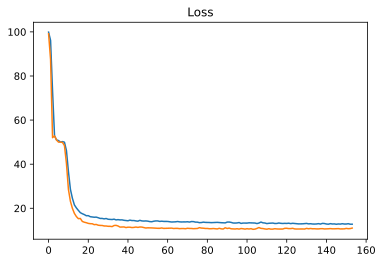

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
model.load_weights('/content/sample_data/best_model.hdf5')
model.save('/content/sample_data/nn_1.hdf5')

In [42]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.45%


10.45 with sigmoid + model.add(L.Dense(256, activation="relu"))

10,70 with logarithm of numerical features
10,60 without logarithm of numerical features


In [43]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

We have made recommendations to improve Model 3:
* It is desirable to feed data into the neural network with a distribution close to normal, so it makes sense to take the logarithm from some numerical features before normalization. 
Related article: https://habr.com/ru/company/ods/blog/325422

* Extracted numeric values from text:
Parsing features 'engineDisplacement', 'enginePower', 'Ownership' to extract numeric values.

* Reduced the dimension of categorical features
The name attribute 'name' contains data that is already in other columns ('enginePower', 'engineDisplacement', 'vehicleTransmission'), so this data can be removed. Then, the dimension should be further reduced, for example, by highlighting the presence of xDrive as a separate feature.

# Model 4: NLP + Multiple Inputs

In [44]:
 data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [23]:
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

In [24]:
#create a function in which there will be both lemmatization and text cleaning
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [25]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
data_NLP['description'] = data_NLP.apply(
    lambda data_NLP: lemmatize(data_NLP.description), axis=1)

In [27]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [28]:
# splitting the data
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [29]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])

CPU times: user 1.05 s, sys: 2.98 ms, total: 1.05 s
Wall time: 1.05 s


In [ ]:
tokenize.word_index

 We have received the resulting dictionary, so we will be able to further vectorize our text.

In [31]:
# % % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [32]:
#this is what our text looks like now
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

Now we are building a network for text processing. We use LSTM in the example:

In [33]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))

model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid")) #add a fully connected layer
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

This network is built "without a head". Let's add another network that we created earlier for tabular data:

In [34]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu")) #adding another fully connected layer
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

It remains to combine them into a Multi-Input network, that is, a network that allows you to take several networks as input and combine their results. The L.concatenate layer is responsible for the union:

In [35]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [36]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3673856     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [37]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint('/content/sample_data/best_model.hdf5', monitor='val_MAPE',
                             save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [39]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=350, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/350
12/12 [==============================] - 104s 9s/step - loss: 99.7325 - MAPE: 99.7325 - val_loss: 96.9006 - val_MAPE: 96.9006
Epoch 2/350
12/12 [==============================] - 109s 9s/step - loss: 77.9777 - MAPE: 77.9777 - val_loss: 57.4440 - val_MAPE: 57.4440
Epoch 3/350
12/12 [==============================] - 107s 9s/step - loss: 55.1472 - MAPE: 55.1472 - val_loss: 52.7925 - val_MAPE: 52.7925
Epoch 4/350
12/12 [==============================] - 107s 9s/step - loss: 50.2696 - MAPE: 50.2696 - val_loss: 48.6361 - val_MAPE: 48.6361
Epoch 5/350
12/12 [==============================] - 108s 9s/step - loss: 45.2905 - MAPE: 45.2905 - val_loss: 38.5833 - val_MAPE: 38.5833
Epoch 6/350
12/12 [==============================] - 109s 9s/step - loss: 35.3030 - MAPE: 35.3030 - val_loss: 29.0479 - val_MAPE: 29.0479
Epoch 7/350
12/12 [==============================] - 107s 9s/step - loss: 28.9005 - MAPE: 28.9005 - val_loss: 22.8816 - val_MAPE: 22.8816
Epoch 8/350
12/12 [===============

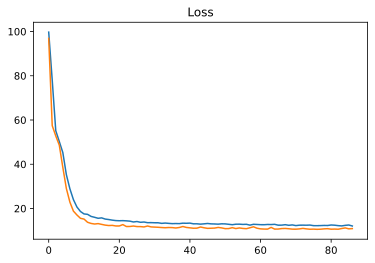

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
model.load_weights('/content/sample_data/best_model.hdf5')
model.save('/content/sample_data/nn_mlp_nlp.hdf5')

In [42]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.57%


TEST mape: 10.88% - without text processing

TEST mape: 10.64% - with text processing

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Conclusion: we slightly changed the network architecture and added BatchNormalization, but this did not lead to an improvement in the end. We also added fully connected layers, which helped us to improve the metric.

# Model 5: Adding images

### Data

In [ ]:
# make sure prices and photos are loaded correctly
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

Let's prepare a version of the image augmentation that worked well in the previous Ford_Ferrari project, thinking about the desired image size

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [ ]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(240, 320)
])

In [ ]:
#example
plt.figure(figsize = (12,8))
for i in range(9):
    img = AUGMENTATIONS(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('application of augmentations', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = AUGMENTATIONS(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
 

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])

In [ ]:
def process_image(image):
    return AUGMENTATIONS(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# check that there are no errors:
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

### Building a convolutional network for image analysis without a "head"

In this part of the work, several different models from the EfficientNet family were tested, but it was decided to use B3, because it gives the most reliable result.

In [ ]:
# normalization is included in the EfficientNetB3 model, so it takes uint8 as input
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet',
                                                                       include_top=False, input_shape=(size[1], size[0], 3))

In [ ]:
# Firstable, the network that was loaded is not trained in any way.
# We will train only the upper layers that we randomly initialized
efficientnet_model.trainable = True

In [ ]:
# We will work with layers starting from now
fine_tune_at = len(efficientnet_model.layers)//2

# Keep all other layers frozen
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# check the number and status of layers
print(len(efficientnet_model.layers))

for layer in efficientnet_model.layers:
    print(layer, layer.trainable)

In [ ]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#building a neural network for tabular data analysis
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),  # change the activation function
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),#added another fully connected layer
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP: slightly change the basic architecture
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(), #added normalization
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'), #added a fully connected layer with sigmoid activation function
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    L.Dropout(0.25)
    ])

In [ ]:
# combine the outputs of three neural networks
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

Let's try to apply ExponentialDecay to control the learning rate

In [ ]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

In [ ]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor='val_MAPE', save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

MAPE B3: 10,82

MAPE B7: 10,9

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [ ]:
blend_predict = (test_predict_catboost +
                 test_predict_nn1[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost +
                     sub_predict_nn1[:, 0] + sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Conclusions:

We did all the necessary work on data preparation, their analysis, processing and preparation for further work. The dataset was cleared of duplicates and outliers, we have performed normalization, and we have used classical methods for coding categorical features. We also have prepared additional features . As a result of the analysis, some features, including those based on correlation analysis, were removed.
We have used classical language processing methods: tokenization and lemmatization.
When working with images, we used our own augmentation code based on the albumentation library. Experiments were carried out with other typical EfficientNet models, some of which led to overfitting.
As a result of blending, we managed to achieve good results of the metric of 10.81. Which currently corresponds to 13th place in the leaderboard.